# predicting model of slaking settlement¶
## import and definition

In [336]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import math 
import numpy.polynomial.polynomial as poly
from scipy.interpolate import interp1d
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.patches as patches
# calculating the brekage 
def relative_br (seive_size, percentage_passing):

    seive_log=np.log10(np.array(seive_size))
    seive_dis=np.array(seive_log)[:-1]-np.array(seive_log)[1:]
    per_dis_100_1cy=(np.array(percentage_passing)[:-1]+np.array(percentage_passing)[1:])/2
    total_100_1cy=((seive_dis)*per_dis_100_1cy).sum()
    seive_dis_init=(np.log10(np.array(seive_size)[0])-np.log10(np.array(seive_size)[1]))*50
    area_inbetween=total_100_1cy-seive_dis_init
    possible_total=(np.log10(np.array(seive_size)[0])-np.log10(np.array(seive_size)[-1]))*100-seive_dis_init
    Br=(area_inbetween/possible_total)
    return (Br)
# calculating the particle size with givein percentage
def parti_size (sei, pass_per, wan_per):
    return(np.interp(wan_per,list(reversed(list(pass_per))),list(reversed(list(sei)))))
def get_sub(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    sub_s = "ₐ₈CDₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
    res = x.maketrans(''.join(normal), ''.join(sub_s))
    return x.translate(res)

# Data and its manipulation

In [585]:
df1= pd. read_excel (r"C:\Users\user\Desktop\python link\master research1.xlsx")#read the settlement related file
df2= pd. read_excel (r"C:\Users\user\Desktop\python link\breakage.xlsx")#read the breakage related file
df1.dropna(subset = ["100 kpa"], inplace=True)


# add columen for dry density (no suffi)
df1["Dry Density 100 kpa"]=1250*(100)/(100-df1["100 kpa"]-1)
df1["Dry Density 200 kpa"]=1250*(100)/(100-df1["200 kpa"]-2.2)
df1["Dry Density 500 kpa"]=1250*(100)/(100-df1["500 kpa"]-4)

# add columen for voids (no suffi)
df1["e-100 kpa"]=(1-(df1["Dry Density 100 kpa"]/2690))/(df1["Dry Density 100 kpa"]/2690)
df1["e-200 kpa"]=(1-(df1["Dry Density 200 kpa"]/2690))/(df1["Dry Density 200 kpa"]/2690)
df1["e-500 kpa"]=(1-(df1["Dry Density 500 kpa"]/2690))/(df1["Dry Density 500 kpa"]/2690)
# add columen for voids (suffi)

df1['e-100 kpa'][0]=1.14229
df1['e-200 kpa'][0]=1.105
df1['e-500 kpa'][0]=1.02
# add columen for relative compaction 
df1['dc-100']=df1['Dry Density 100 kpa']/1650*100
df1['dc-200']=df1['Dry Density 200 kpa']/1650*100
df1['dc-500']=df1['Dry Density 500 kpa']/1650*100


## rearranging the data only for dry

In [372]:
#only dry and not for first wetting 
#100
t0_100=np.array(df1['e-100 kpa'][::2])#e
t1_100=t0_100-np.ones(len(t0_100))*t0_100[-1]#differnce from nc line
e_cum_100=np.cumsum(t1_100)# cumulative differnce from nc line
s_cum_100=np.array(df1["100 kpa"][::2])# cumulative dry strain
s1_100=-(s_cum_100[:-1]-s_cum_100[1:])[:]
#200
t0_200=np.array(df1['e-200 kpa'][::2])#e
t1_200=t0_200-np.ones(len(t0_200))*t0_200[-1]#differnce from nc line
e_cum_200=np.cumsum(t1_200)# cumulative differnce from nc line
s_cum_200=np.array(df1["200 kpa"][::2])# cumulative dry strain
s1_200=-(s_cum_200[:-1]-s_cum_200[1:])[:]
#500
t0_500=np.array(df1['e-500 kpa'][::2])#e
t1_500=t0_500-np.ones(len(t0_500))*t0_500[-1]#differnce from nc line
e_cum_500=np.cumsum(t1_500)# cumulative differnce from nc line
s_cum_500=np.array(df1["500 kpa"][::2])# cumulative dry strain
s1_500=-(s_cum_500[:-1]-s_cum_500[1:])[:]

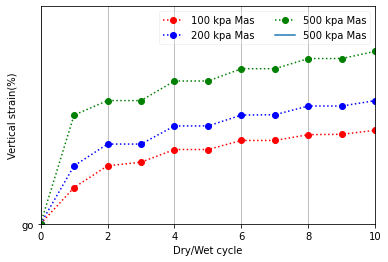

In [714]:
plt.figure()

plt.plot(np.linspace(0, 18,19),df1["100 kpa"][:-1],'o:r',label='100 kpa Mas')
plt.plot(np.linspace(0, 18,19),df1["200 kpa"][:-1],'o:b',label='200 kpa Mas')
plt.plot(np.linspace(0, 18,19),df1["500 kpa"][:-1],'o:g','go',label='500 kpa Mas')

plt.xlabel('Dry/Wet cycle')
plt.ylabel('Vertical strain(%)')
plt.legend(loc='best',framealpha=0.25,ncol=2)
plt.xlim(0,10)
plt.ylim(0,30)
plt.grid(True)
plt.show()


In [230]:
# breakage of 3 points
Br_100=[relative_br(df2['seive'],df2['100-1cy']),relative_br(df2['seive'],df2['100-5cy']),relative_br(df2['seive'],df2['100-9cy'])]
Br_200=[relative_br(df2['seive'],df2['200-1cy']),relative_br(df2['seive'],df2['200-5cy']),relative_br(df2['seive'],df2['200-9cy'])]
Br_500=[relative_br(df2['seive'],df2['500-1cy']),relative_br(df2['seive'],df2['500-5cy']),relative_br(df2['seive'],df2['500-9cy'])]
# strain of those point
#strain_100=[(df1.loc[df1['no of cycle']==1, '100 kpa'].iloc[0]),(df1.loc[df1['no of cycle']==5, '100 kpa'].iloc[0]),(df1.loc[df1['no of cycle']==9, '100 kpa'].iloc[0])]
#strain_200=[(df1.loc[df1['no of cycle']==1, '200 kpa'].iloc[0]),(df1.loc[df1['no of cycle']==5, '200 kpa'].iloc[0]),(df1.loc[df1['no of cycle']==9, '200 kpa'].iloc[0])]
#strain_500=[(df1.loc[df1['no of cycle']==1, '500 kpa'].iloc[0]),(df1.loc[df1['no of cycle']==5, '500 kpa'].iloc[0]),(df1.loc[df1['no of cycle']==9, '500 kpa'].iloc[0])]
# cumulative e
e_cum_100_159=[e_cum_100[1],e_cum_100[5],e_cum_100[9]]
e_cum_200_159=[e_cum_200[1],e_cum_200[5],e_cum_200[9]]
e_cum_500_159=[e_cum_500[1],e_cum_500[5],e_cum_500[9]]

In [833]:
e_cum_100[1:]-e_cum_100[:-1]

array([0.1190056, 0.0705856, 0.0436856, 0.0264696, 0.0135576, 0.0049496,
       0.0017216, 0.0006456, 0.       ])

In [835]:
np.insert(e_cum_100[1:]-e_cum_100[:-1],0,e_cum_100[0])

array([0.3029756, 0.1190056, 0.0705856, 0.0436856, 0.0264696, 0.0135576,
       0.0049496, 0.0017216, 0.0006456, 0.       ])

In [885]:
from basic_units import cm
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt


xcenter, ycenter = 0.38*cm, 0.52*cm
width, height = 1e-1*cm, 3e-1*cm
angle = -30

theta = np.deg2rad(np.arange(0.0, 360.0, 1.0))
x = 0.5 * width * np.cos(theta)
y = 0.5 * height * np.sin(theta)

rtheta = np.radians(angle)
R = np.array([
    [np.cos(rtheta), -np.sin(rtheta)],
    [np.sin(rtheta),  np.cos(rtheta)],
    ])


x, y = np.dot(R, np.array([x, y]))
x += xcenter
y += ycenter
fig = plt.figure()
ax = fig.add_subplot(211, aspect='auto')
ax.fill(x, y, alpha=0.2, facecolor='yellow',
        edgecolor='yellow', linewidth=1, zorder=1)

e1 = patches.Ellipse((xcenter, ycenter), width, height,
                     angle=angle, linewidth=2, fill=False, zorder=2)

ax.add_patch(e1)

ax = fig.add_subplot(212, aspect='equal')
ax.fill(x, y, alpha=0.2, facecolor='green', edgecolor='green', zorder=1)
e2 = patches.Ellipse((xcenter, ycenter), width, height,
                     angle=angle, linewidth=2, fill=False, zorder=2)


ax.add_patch(e2)
plt.show()

ModuleNotFoundError: No module named 'basic_units'

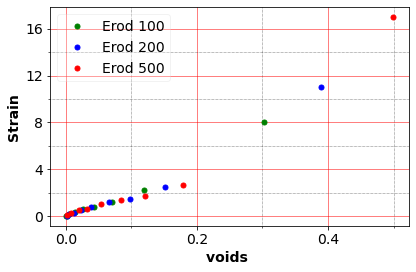

In [919]:
plt.rcParams.update({'font.size': 14})




#########################
fig5,(ax5e)=plt.subplots()
# breakage of particle 
ax5d.plot(e_cum_100_159,Br_100,color='green', marker="o", linestyle='-',linewidth=1, markersize=3, label='Erod 100')
ax5d.plot(e_cum_200_159,Br_200,color='b', marker="o", linestyle='-',linewidth=1, markersize=3, label='Erod 200')
ax5d.plot(e_cum_500_159,Br_500,color='r', marker="o", linestyle='-',linewidth=1, markersize=3, label='Erod 500')
ax5d.legend(loc='upper left',framealpha=0.25)
ax5d.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax5d.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax5d.set_ylabel('Breakage',fontweight='bold')
ax5d.set_xlabel('Cumulative voilds',fontweight='bold')
ax5d.set_ylim(-0.1,1)
ax5d.xaxis.set_major_locator(MultipleLocator(0.2))
ax5d.xaxis.set_minor_locator(MultipleLocator(0.1))
ax5d.yaxis.set_major_locator(MultipleLocator(0.2))
ax5d.yaxis.set_minor_locator(MultipleLocator(0.1))
# cumulative of voids 

ax5e.plot(np.insert(e_cum_100[1:]-e_cum_100[:-1],0,e_cum_100[0])[:-1],s_cum_100[1:]-s_cum_100[:-1], color='green', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 100')
ax5e.plot(np.insert(e_cum_200[1:]-e_cum_200[:-1],0,e_cum_200[0])[:-1],s_cum_200[1:]-s_cum_200[:-1],color='b', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 200')
ax5e.plot(np.insert(e_cum_500[1:]-e_cum_500[:-1],0,e_cum_500[0])[:-1],s_cum_500[1:]-s_cum_500[:-1], color='r', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 500')
ax5e.legend(loc='upper left',framealpha=0.25)
ax5e.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax5e.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax5e.set_ylabel('Strain',fontweight='bold')
ax5e.set_xlabel('voids ',fontweight='bold')
ax5e.xaxis.set_major_locator(MultipleLocator(0.2))
ax5e.xaxis.set_minor_locator(MultipleLocator(0.1))
# plt.xlim(0.12, 0)
ax5e.yaxis.set_major_locator(MultipleLocator(4))
ax5e.yaxis.set_minor_locator(MultipleLocator(2))

# voids vs cycle
# e_cy_100= e_cum_100[:-1]-e_cum_100[1:]
# e_cy_200= e_cum_200[:-1]-e_cum_200[1:]
# e_cy_1500= e_cum_500[:-1]-e_cum_500[1:]


fig5.tight_layout()
plt.show()


# relative voids from NC line

In [232]:
# r_e_100= -(t0_100[1:]-t0_100[:-1])[1:]/((t1_100[1:-1])**1.2)
# r_e_200= -(t0_200[1:]-t0_200[:-1])[1:2]/((t1_200[1:-3])**1.2)
# r_e_500= -(t0_500[1:]-t0_500[:-1])[1:]/((t1_500[1:-1])**1.2) 

r_e_100= -(t0_100[:]-t0_100[:-1])[1:]
r_e_200= -(t0_200[1:]-t0_200[:-1])[1:]
r_e_500= -(t0_500[1:]-t0_500[:-1])[1:]

# gekko moldel 
## import/data setting 


In [716]:
from gekko import GEKKO
e_in=np.concatenate([np.ones(len(e_cum_100[0:-1]))*e_cum_100[0],np.ones(len(e_cum_500[0:-1]))*e_cum_500[0]])#e for collopse (after loading )
L_in=np.concatenate([np.ones(len(e_cum_100[0:-1]))*100,np.ones(len(e_cum_500[0:-1]))*500])/1000
L_cy=np.concatenate([np.ones(len(e_cum_100[0:-1]))*100,np.ones(len(e_cum_500[0:-1]))*500])/1000
e_cy=np.concatenate([e_cum_100[0:-1]-e_cum_100[0],e_cum_500[0:-1]-e_cum_500[0]])
s_t_cy=np.concatenate([s_cum_100[1:],s_cum_500[1:]])

L_in_cy=np.concatenate([np.ones(len(e_cum_100[0:-1]))*100],[np.ones(len(e_cum_200[0:-1]))*200],[np.ones(len(e_cum_500[0:-1]))*500])
e_cy=np.concatenate([e_cum_100[0:-1]-e_cum_100[0],e_cum_200[0:-1]-e_cum_200[0],e_cum_500[0:-1]-e_cum_500[0]])
s_t_cy=np.concatenate([s_cum_100[1:],s_cum_200[1:],s_cum_500[1:]])

## define the variable 

In [720]:
cof_load=np.concatenate([np.ones(len(t1_100[:-1]))*100,np.ones(len(t1_500[:-1]))*500])
cof_e=np.concatenate([t1_100[:-1],t1_500[:-1]])
cof_strain=np.concatenate([s1_100[:], s1_500[:]])
cof_e[0]=0
cof_e[9]=0


cof_e_in=np.zeros(len(cof_e))
cof_e_in[0]=e_in[0]
cof_e_in[9]=e_in[9]


In [722]:
xm1 = np.array(cof_e) # cumulative voids after the collapse not last one minus the collapse voids
xm2 = np.array(L_cy)  # load commmon
xm3 = np.array(e_in) # collapase voids
xm4= np.array(L_in) 
 
ym = np.array(s_t_cy)

xm1

# only cycle predition

In [725]:
cof_load_cy=np.concatenate([np.ones(len(t1_100[1:-1]))*100,np.ones(len(t1_500[1:-1]))*500])
index = [0, 9]
cof_e_in=[e_cum_100[0],e_cum_500[0]]
cof_load_in=[100,500]
cof_strain_in=[s_t_cy[0],s_t_cy[9]]
cof_e_cy = np.delete(cof_e, index)
cof_strain_cy=np.delete(cof_strain,index)

In [736]:
cof_e_cy,cof_load_cy,cof_strain_cy

(array([0.1190056, 0.0705856, 0.0436856, 0.0264696, 0.0135576, 0.0049496,
        0.0017216, 0.0006456, 0.178616 , 0.120512 , 0.083928 , 0.0538   ,
        0.03228  , 0.019368 , 0.008608 , 0.002152 ]),
 array([100., 100., 100., 100., 100., 100., 100., 100., 500., 500., 500.,
        500., 500., 500., 500., 500.]),
 array([2.25, 1.25, 0.8 , 0.6 , 0.4 , 0.15, 0.05, 0.03, 2.7 , 1.7 , 1.4 ,
        1.  , 0.6 , 0.5 , 0.3 , 0.1 ]))

 ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  7
   Intermediates:  0
   Connections  :  0
   Equations    :  2
   Residuals    :  2
 
 Number of state variables:    19
 Number of total equations: -  16
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    3
 
 ----------------------------------------------
 Model Parameter Estimation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  4.49020E+04  1.38987E-01
    1  7.56134E+05  5.55112E-17
    2  5.87836E+04  1.23797E-01
    3  1.18447E+02  2.40490E-01
    4  7.91053E+00  4.20294E-04
    5  7.72071E+00  3.59126E-05
    6  7.44391E+00  7.08561E-04
    7  7.35818E+00

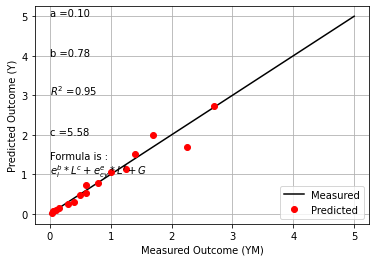

In [807]:
xm1 = np.array(cof_load_cy) # cumulative voids after the collapse not last one minus the collapse voids
xm2 = np.array(cof_e_cy)
ym3 = np.array(cof_strain_cy)

m3 = GEKKO(remote=False)

a = m3.FV(lb=0.1,ub=100.0)
b = m3.FV(lb=0.1,ub=100.0)
c = m3.FV(lb=0.1,ub=100.0)


x1 = m3.Param(value=xm1)
x2 = m3.Param(value=xm2)

z3 = m3.Param(value=ym3)
y3 = m3.Var()
m3.Equation(y3==c*(x1**a)*(x2**b))
m3.Minimize(((y3-z3)/z3)**2)
# Options

a.STATUS = 1
b.STATUS = 1
c.STATUS = 1


m3.options.IMODE = 2
m3.options.SOLVER = 1
# Solve
m3.solve(disp=True)

print('a: ', a.value[0])
print('b: ', b.value[0])
print('c: ', c.value[0])


# print('A: ', A.value[0])

##################################################################################################
cFormula = "Formula is : " + "\n" + \
           r"$e_i^b*L^c + e_{cy}^e*L^f + G $"

from scipy import stats
slope, intercept, r_value, p_value, \
       std_err = stats.linregress(ym3,y3)

r2 = r_value**2
cR2 = "R^2 correlation = " + str(r_value**2)
# print(cR2)

# plot solution
plt.figure(1)
plt.plot([0,5],[0,5],'k-',label='Measured')
plt.plot(ym3,y3,'ro',label='Predicted')
plt.xlabel('Measured Outcome (YM)')
plt.ylabel('Predicted Outcome (Y)')
plt.legend(loc='lower right')

plt.text(0,5,'a =' + "{:.2f}".format(a.value[0])) 
plt.text(0,4,'b =' + "{:.2f}".format(b.value[0])) 
plt.text(0,2,'c =' + "{:.2f}".format(c.value[0])) 



plt.text(0,3,r'$R^2$ =' + "{:.2f}".format(r_value**2)) 
plt.text(0,1,cFormula)
plt.grid(True)
plt.show()
cFormula = "Formula is : " + "\n" + \
r"$D * Voids^E * Load^f + G$"
cy_pre=y3

In [796]:
cof_load_in,cof_e_in,cof_strain_in

([100, 500], [0.3029756, 0.498536], [8.0, 17.0])

 ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  6
   Intermediates:  0
   Connections  :  0
   Equations    :  2
   Residuals    :  2
 
 Number of state variables:    4
 Number of total equations: -  2
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    2
 
 ----------------------------------------------
 Model Parameter Estimation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  2.83629E+00  2.17058E-01
    1  1.46719E+00  2.07925E-01
    2  2.99058E-01  5.05553E-02
    3  1.44645E-01  1.14091E-01
    4  6.29961E-01  3.11269E-02
    5  4.94111E-03  3.26364E-02
    6  5.84100E-03  3.07247E-02
    7  1.43054E-03  

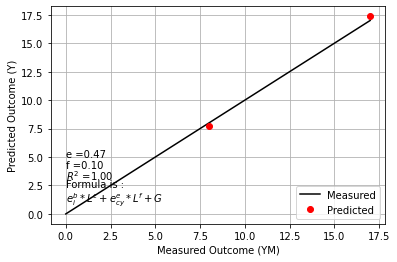

In [797]:
xm1 = np.array(cof_load_in) # cumulative voids after the collapse not last one minus the collapse voids
xm2 = np.array(cof_e_in)
ym4 = np.array(cof_strain_in)

m4 = GEKKO(remote=False)

e = m4.FV(lb=0.1,ub=100.0)
f = m4.FV(lb=0.1,ub=100.0)
# c = m3.FV(lb=0.1,ub=100.0)


x1 = m4.Param(value=xm1)
x2 = m4.Param(value=xm2)

z4 = m4.Param(value=ym4)
y4 = m4.Var()
m4.Equation(y4==(x1**e)*(x2**f))
m4.Minimize(((y4-z4)/z4)**2)
# Options

e.STATUS = 1
f.STATUS = 1
# c.STATUS = 1


m4.options.IMODE = 2
m4.options.SOLVER = 1
# Solve
m4.solve(disp=True)

print('e: ', e.value[0])
print('f: ', f.value[0])
# print('c: ', c.value[0])


# print('A: ', A.value[0])

##################################################################################################
cFormula = "Formula is : " + "\n" + \
           r"$e_i^b*L^c + e_{cy}^e*L^f + G $"

from scipy import stats
slope, intercept, r_value, p_value, \
       std_err = stats.linregress(ym4,y4)

r2 = r_value**2
cR2 = "R^2 correlation = " + str(r_value**2)
print(cR2)

# plot solution
plt.figure(1)
plt.plot([0,17],[0,17],'k-',label='Measured')
plt.plot(ym4,y4,'ro',label='Predicted')
plt.xlabel('Measured Outcome (YM)')
plt.ylabel('Predicted Outcome (Y)')
plt.legend(loc='lower right')

plt.text(0,5,'e =' + "{:.2f}".format(e.value[0])) 
plt.text(0,4,'f =' + "{:.2f}".format(f.value[0])) 
# plt.text(0,2,'c =' + "{:.2f}".format(c.value[0])) 



plt.text(0,3,r'$R^2$ =' + "{:.2f}".format(r_value**2)) 
plt.text(0,1,cFormula)
plt.grid(True)
plt.show()
cFormula = "Formula is : " + "\n" + \
r"$D * Voids^E * Load^f + G$"

In [798]:
pre_100=cy_pre[0:8]

pre_500=cy_pre[8:16]
pre_100.insert(0,y4[0])

pre_500.insert(0,y4[1])


In [799]:
pre_100

[7.7502430102,
 1.6883557699,
 1.1246466978,
 0.77434976449,
 0.52443557563,
 0.31166446288,
 0.14233328706,
 0.062599671132,
 0.029190940255]

In [800]:
s_cum_100[1:]


array([ 8.  , 10.25, 11.5 , 12.3 , 12.9 , 13.3 , 13.45, 13.5 , 13.53])

In [801]:
zzz

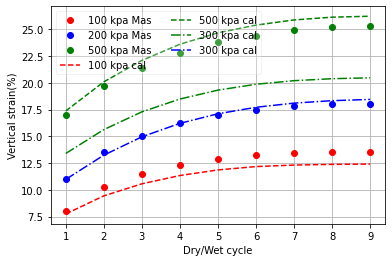

R^2 correlation = 0.9970948696461154


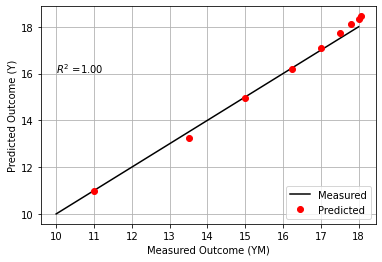

'$D * Voids^E * Load^f + G$'

In [814]:
plt.figure()

plt.plot(np.linspace(1, 9,9),s_cum_100[1:],'ro',label='100 kpa Mas')
plt.plot(np.linspace(1, 9,9),s_cum_200[1:],'bo',label='200 kpa Mas')
plt.plot(np.linspace(1, 9,9),s_cum_500[1:],'go',label='500 kpa Mas')
plt.plot(np.linspace(1, 9,9),np.cumsum(pre_100),'r--',label='100 kpa cal')
#plt.plot(np.linspace(1, 9,9),np.cumsum(pre_200),'b--',label='200 kpa cal')
plt.plot(np.linspace(1, 9,9),np.cumsum(pre_500),'g--',label='500 kpa cal')
plt.plot(np.linspace(1, 9,9),pre_strain(in_e_300,nc_e_300, 9, 300),'g-.',label='300 kpa cal')
plt.plot(np.linspace(1, 9,9),pre_strain(in_e_200,nc_e_200, 9, 200),'b-.',label='300 kpa cal')
pre_strain(in_e_300,nc_e_300, 9, 300)
plt.xlabel('Dry/Wet cycle')
plt.ylabel('Vertical strain(%)')
plt.legend(loc='best',framealpha=0.25,ncol=2)

plt.grid(True)
plt.show()

from scipy import stats
slope, intercept, r_value, p_value, \
       std_err = stats.linregress(s_cum_200[1:],pre_strain(in_e_200,nc_e_200, 9, 200))

r2 = r_value**2
cR2 = "R^2 correlation = " + str(r_value**2)
print(cR2)

# plot solution
plt.figure(1)
plt.plot([10,18],[10,18],'k-',label='Measured')
plt.plot(s_cum_200[1:],pre_strain(in_e_200,nc_e_200, 9, 200),'ro',label='Predicted')
plt.xlabel('Measured Outcome (YM)')
plt.ylabel('Predicted Outcome (Y)')
plt.legend(loc='lower right')

# plt.text(0,5,'e =' + "{:.2f}".format(e.value[0])) 
# plt.text(0,4,'f =' + "{:.2f}".format(f.value[0])) 
# plt.text(0,2,'c =' + "{:.2f}".format(c.value[0])) 



plt.text(10,16,r'$R^2$ =' + "{:.2f}".format(r_value**2)) 
# plt.text(0,1,cFormula)
plt.grid(True)
plt.show()
# cFormula = "Formula is : " + "\n" + \
r"$D * Voids^E * Load^f + G$"

# prediction of 300 kpa

In [803]:
(s_cum_200[1:]),np.array(pre_strain(in_e_200,nc_e_200, 9, 200)),r_value

(array([11.  , 13.5 , 15.  , 16.25, 17.  , 17.5 , 17.8 , 18.  , 18.05]),
 array([10.84887616, 12.68104163, 14.02953142, 14.98600839, 15.63247448,
        16.04144038, 16.27609661, 16.39047884, 16.42957445]),
 0.9996482290000339)

R^2 correlation = 0.9970948696461154


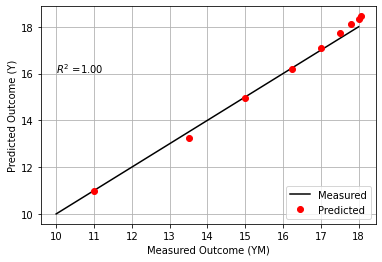

'$D * Voids^E * Load^f + G$'

In [812]:
from scipy import stats
slope, intercept, r_value, p_value, \
       std_err = stats.linregress(s_cum_200[1:],pre_strain(in_e_200,nc_e_200, 9, 200))

r2 = r_value**2
cR2 = "R^2 correlation = " + str(r_value**2)
print(cR2)

# plot solution
plt.figure(1)
plt.plot([10,18],[10,18],'k-',label='Measured')
plt.plot(s_cum_200[1:],pre_strain(in_e_200,nc_e_200, 9, 200),'ro',label='Predicted')
plt.xlabel('Measured Outcome (YM)')
plt.ylabel('Predicted Outcome (Y)')
plt.legend(loc='lower right')

# plt.text(0,5,'e =' + "{:.2f}".format(e.value[0])) 
# plt.text(0,4,'f =' + "{:.2f}".format(f.value[0])) 
# plt.text(0,2,'c =' + "{:.2f}".format(c.value[0])) 



plt.text(10,16,r'$R^2$ =' + "{:.2f}".format(r_value**2)) 
# plt.text(0,1,cFormula)
plt.grid(True)
plt.show()
# cFormula = "Formula is : " + "\n" + \
r"$D * Voids^E * Load^f + G$"

In [805]:
df3=pd.read_excel(r"C:\Users\user\Desktop\python link\voids vs load.xlsx")
in_e_300=np.interp(300,df3["loading"],df3["voids-load"])
nc_e_300=np.interp(300,[200,500],[t0_200[-1],t0_500[-1]])
no_cycle=9
load=300

In [809]:
in_e_200=np.interp(200,df3["loading"],df3["voids-load"])
nc_e_200=0.7162
no_cycle=9
load=200

In [810]:
nc_e_200,t0_200[-1]

(0.7162, 0.7162200000000002)

In [811]:
def pre_strain (in_e,nc_e,no_cycle,load):
    strain_pre=[]
    
    # initial strain
    str_in=load**0.47*(in_e-nc_e)**0.1
    strain_pre.insert(0,str_in)
    ini1=[]
    ini=in_e*(1-((str_in)/100))-(str_in)/100
    for i in range(8):
        strain_pre.append(strain_pre[i]+5.61*load**0.1*(ini-nc_e)**0.78)
        ini=in_e*(1-((strain_pre[i+1])/100))-(strain_pre[i+1])/100
        ini1.append(in_e*(1-(strain_pre[i+1])/97)-(strain_pre[i+1])/97)
    return strain_pre
        
        
    


In [786]:
ym3,y3,stats.linregress(ym3,y3)

(array([2.25, 1.25, 0.8 , 0.6 , 0.4 , 0.15, 0.05, 0.03, 2.7 , 1.7 , 1.4 ,
        1.  , 0.6 , 0.5 , 0.3 , 0.1 ]),
 [1.6883557699, 1.1246466978, 0.77434976449, 0.52443557563, 0.31166446288, 0.14233328706, 0.062599671132, 0.029190940255, 2.7197599348, 2.0026731602, 1.5114627805, 1.0695045995, 0.71882941625, 0.48313558435, 0.2571206315, 0.087467539269],
 LinregressResult(slope=0.958667657331956, intercept=0.015572257163440573, rvalue=0.975791575777818, pvalue=1.2256585132307972e-10, stderr=0.05742497553052748, intercept_stderr=0.06681578515358402))

In [710]:
pre_strain(in_e_300,nc_e_300, 9, 300),cof_e_cy

(([12.949659690320999,
   15.33076490303518,
   17.10873745145729,
   18.393145502322977,
   19.28246599843613,
   19.864276398135647,
   20.215449196827823,
   20.40234522038525,
   20.48098415573127],
  array([ 0.09735243,  0.05928352,  0.03178253,  0.01274092,  0.00028354,
         -0.00723557, -0.01123728, -0.01292105])),
 array([0.1190056, 0.0705856, 0.0436856, 0.0264696, 0.0135576, 0.0049496,
        0.0017216, 0.0006456, 0.151716 , 0.097916 , 0.065636 , 0.038736 ,
        0.022596 , 0.011836 , 0.00538  , 0.001076 , 0.178616 , 0.120512 ,
        0.083928 , 0.0538   , 0.03228  , 0.019368 , 0.008608 , 0.002152 ]))

In [757]:
pre_strain(in_e_200,nc_e_200, 9, 200)

[9.550003401525537,
 11.39681583861104,
 12.76429824238251,
 13.741724572258477,
 14.409114288919849,
 14.837393893532422,
 15.088560265145636,
 15.215840743071917,
 15.263817474909589]

In [921]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(pre_strain(in_e_200,nc_e_200, 9, 200),s_cum_200[1:]) 

In [922]:
coefficient_of_dermination

0.9908735083555548